In [1]:
# Import stardard python libraries:
import numpy as np
import matplotlib.pyplot as plt

# Import astropy, mirage, seaborn for plots:
import batman
import astropy.units as q
from mirage.soss_simulator import SossSim
import seaborn
seaborn.set_style('ticks')

# Import utils script:
import utils

## 1. Introduction
---------------

Let's first use our `utils` script to generate a stellar spectrum consistent with WASP-43. First, define stellar properties of WASP-43:

In [2]:
teff, logg, feh, jmag = 4520, 4.6, -0.01, 8

Our `utils` script can get the closest ATLAS or PHOENIX spectrum for those properties. Let's use the ATLAS spectrum:

In [3]:
star_wavelength, star_flux = utils.get_stellar_model(teff=teff, logg=logg, feh=feh, jmag=jmag)

Let's plot this:

Text(0.5, 1.0, 'Stellar spectrum of WASP-43')

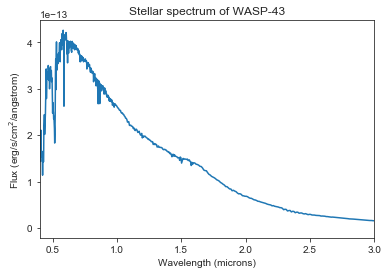

In [4]:
plt.plot(star_wavelength, star_flux)
plt.xlim(0.4,3.)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux (erg/s/cm$^2$/angstrom)')
plt.title('Stellar spectrum of WASP-43')

Let's similarly define a flat transit spectrum for WASP-43b:

In [5]:
planet_wavelength, planet_tspectrum = np.copy(star_wavelength), np.ones([len(star_wavelength)])*0.0136059394

## 2. Running `mirage`
---------------

All right, now we can do a test run of `mirage` with SOSS --- note I'm using _my_ fork of `mirage` (https://github.com/nespinoza/mirage/tree/add_soss) which fixes some bugs we were seeing. 

### 2.1 Setting the transit model

The very first thing we need to do is to generate a transit model `tmodel` and its parameters `params` using `batman` so `mirage` can inject those into the PSFs themselves. 

We first get the properties of WASP-43b from Kreidberg et al. (2014), and inject those in the `params` object. Let's assume we will be observing the transit of WASP-43b which occurrs on `2459819.131474` (August 27, 2022 --- at about 15:09 UT; note the `yaml` file is set to observe around this time indeed): 

In [6]:
params = batman.TransitParams()
params.t0 = 2459819.131474
params.per = 0.81347436
params.a = 4.87
params.inc = 82.10
params.ecc = 0.
params.w = 90.
params.limb_dark = 'quadratic'
params.u = [0.5,0.5]   # These are placeholders; they are changed internally
params.rp = 0.1166445  # These are placeholders; they are changed internally

Now create the `TransitModel` object; inject stellar info as well here. This is useful for calculating limb-darkening:

In [9]:
tmodel = batman.TransitModel(params, np.array([0.])) # Time array is placeholder, will be changed internally by MIRAGE
tmodel.teff, tmodel.logg, tmodel.feh = teff, logg, feh

### 2.2 Run `mirage` with `SossSim`

All right, now we ingest all this to `mirage` --- if you don't have `exoctk`, this will set limb-darkening to zero (which is what we want for now I believe!):

In [10]:
sim = SossSim(paramfile = 'files/niriss_soss_substrip256_clear.yaml', \
              star=[star_wavelength, star_flux], \
              planet=[planet_wavelength, planet_tspectrum],\
              tmodel = tmodel)

No module named 'exoctk'
There was a problem computing those limb darkening coefficients. Using all zeros.
No module named 'exoctk'
There was a problem computing those limb darkening coefficients. Using all zeros.


And, let's create the exposure! This should take a while:

In [ ]:
sim.create(params=params)

2021-03-16 00:21:08,889 - mirage.soss_simulator - INFO - 

Running soss_simulator....



2021-03-16 00:21:08,889 - stpipe - INFO - 

Running soss_simulator....



2021-03-16 00:21:08,889 - stpipe - INFO - 

Running soss_simulator....

2021-03-16 00:21:08,894 - mirage.soss_simulator - INFO - Using parameter file: 


2021-03-16 00:21:08,894 - stpipe - INFO - Using parameter file: 


2021-03-16 00:21:08,894 - stpipe - INFO - Using parameter file: 
2021-03-16 00:21:08,897 - mirage.soss_simulator - INFO - files/niriss_soss_substrip256_clear.yaml


2021-03-16 00:21:08,897 - stpipe - INFO - files/niriss_soss_substrip256_clear.yaml


2021-03-16 00:21:08,897 - stpipe - INFO - files/niriss_soss_substrip256_clear.yaml
Simulating WASP43 in WASP43 transit observation
Configuration: SUBSTRIP256 + CLEAR
Groups: 6, Integrations: 420

Constructing frames for chunk 1/53...
Chunk 1/53 finished: 71.965 s
Constructing frames for chunk 2/53...
Chunk 2/53 finished: 72.911 s
Constructing frames for chunk 3/53...


Let's read in the simulated data and plot one integration:

In [12]:
from astropy.io import fits

In [14]:
w43 = fits.open('WASP43_NIS_SOSS_CLEAR_uncal.fits')

In [15]:
data = w43['SCI'].data

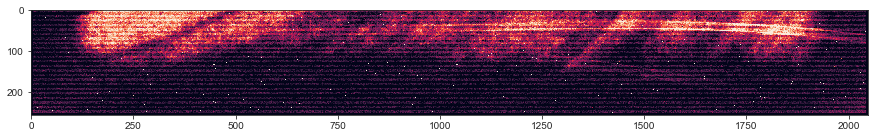

In [21]:
plt.figure(figsize=(15,5))
im = plt.imshow(data[0,2,:,:])
im.set_clim(10000,20000)